# Research for TA and Testing

In [12]:
import pandas as pd
import ccxt
import numpy as np
import matplotlib.pyplot as plt
import pandas_ta as ta
import tensorflow as tf

# Data Collection

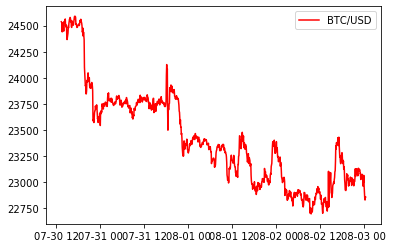

In [13]:
exchange = ccxt.binanceus()

def get_data():
    data = exchange.fetch_ohlcv('BTC/USD', '5m', limit=1000)
    df = pd.DataFrame(data, columns=['date', 'open', 'high', 'low', 'close', 'volume'])
    df['datetime'] = pd.to_datetime(df['date'], unit='ms')
    return df
df = get_data()
plt.plot(df['datetime'], df['close'], color = 'red')
plt.legend(['BTC/USD'])


In [14]:
df = get_data()
MACD = ta.macd(df['close'], n_fast=12, n_slow=26, n_sign=9)
MACD

,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9
0,NaN,NaN,NaN
1,NaN,NaN,NaN
2,NaN,NaN,NaN
3,NaN,NaN,NaN
4,NaN,NaN,NaN
...,...,...,...
995,-27.578879,-15.157457,-12.421421
996,-38.509318,-20.870318,-17.639001
997,-47.958417,-24.255533,-23.702884
998,-52.740948,-23.230451,-29.510497


In [15]:
df = get_data()
ta.stochrsi(df['close'], n=14)

,STOCHRSIk_14_14_3_3,STOCHRSId_14_14_3_3
0,NaN,NaN
1,NaN,NaN
2,NaN,NaN
3,NaN,NaN
4,NaN,NaN
...,...,...
995,35.094638,40.809000
996,9.045549,29.400888
997,0.000000,14.713396
998,5.859458,4.968336


In [16]:
df = get_data()
bollinger = ta.bbands(df['close'], n=20, k=2)
bollinger

,BBL_5_2.0,BBM_5_2.0,BBU_5_2.0,BBB_5_2.0,BBP_5_2.0
0,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN
4,24438.884454,24511.052,24583.219546,0.588857,0.593865
...,...,...,...,...,...
995,22867.416000,22978.096,23088.776000,0.963352,0.105999
996,22794.938399,22948.230,23101.521601,1.335978,0.151612
997,22742.408970,22914.938,23087.467030,1.505821,0.238832
998,22778.694847,22872.868,22967.041153,0.823449,0.382939


Text(0.5, 1.0, 'STOCHRSI')

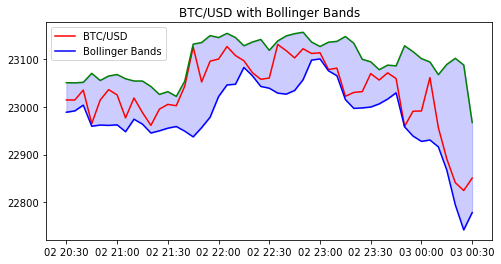

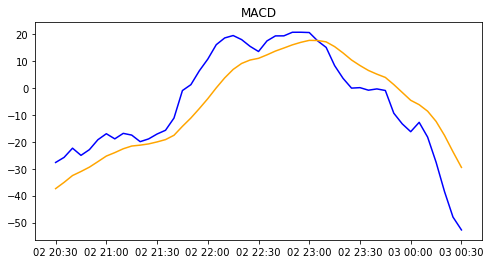

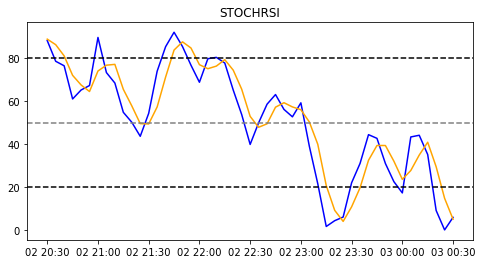

In [17]:
df = get_data()
MACD = ta.macd(df['close'], n_fast=12, n_slow=26, n_sign=9)
stochrsi = ta.stochrsi(df['close'], n=14)
bollinger = ta.bbands(df['close'], n=20, k=2)

plt.figure(figsize=(8, 4))
plt.plot(df['datetime'].iloc[-50:-1], df['close'].iloc[-50:-1], color='red')
plt.plot(df['datetime'].iloc[-50:-1],
         bollinger['BBL_5_2.0'].iloc[-50:-1], color='blue')
plt.plot(df['datetime'].iloc[-50:-1],
         bollinger['BBU_5_2.0'].iloc[-50:-1], color='green')
plt.fill_between(df['datetime'].iloc[-50:-1], bollinger['BBL_5_2.0'].iloc[-50:-1], bollinger['BBU_5_2.0'].iloc[-50:-1], color='blue', alpha=0.2)
plt.legend(['BTC/USD', 'Bollinger Bands'])
plt.title('BTC/USD with Bollinger Bands')

plt.figure(figsize=(8, 4))
plt.plot(df['datetime'].iloc[-50:-1], MACD['MACD_12_26_9'].iloc[-50:-1], color='blue')
plt.plot(df['datetime'].iloc[-50:-1], MACD['MACDs_12_26_9'].iloc[-50:-1], color='orange')
plt.title('MACD')

plt.figure(figsize=(8, 4))
plt.plot(df['datetime'].iloc[-50:-1],
         stochrsi['STOCHRSIk_14_14_3_3'].iloc[-50:-1], color='blue')
plt.plot(df['datetime'].iloc[-50:-1],
         stochrsi['STOCHRSId_14_14_3_3'].iloc[-50:-1], color='orange')
plt.axhline(y=50, color='gray', linestyle='--')
plt.axhline(y=80, color='black', linestyle='--')
plt.axhline(y=20, color='black', linestyle='--')
plt.title('STOCHRSI')


# Ordering Algorithms

The strategy that will be implemented will be MACD focused with the confirmation from the STOCHRSI.  
<br>
If the difference of the MACD is positive, the strategy will be to buy the stock if the STOCHRSI is above the 50% level, indicating a strong trend. This will trigger an OCO order.
<br>
The stop loss will be set to -0.2% of the current price. and the Take-Profit will be 0.5% of the current price
<br>

# ML Integration
- Predict how much higher percentage the stock will be in 30 minutes.
    - Uses a Random Forest Classifier to predict the percentage increases.
    - Uses MACD, STOCHRSI, Volume, Bollinger Bands, and Close Price as features for linear regression to predict the next 30 minutes.


In [18]:
df = get_data()
df['MACD'] = ta.macd(df['close'], n_fast=12, n_slow=26,
                     n_sign=9)['MACDh_12_26_9']
df['STOCHRSIk'] = ta.stochrsi(df['close'], n=14)['STOCHRSIk_14_14_3_3']
df['STOCHRSId'] = ta.stochrsi(df['close'], n=14)['STOCHRSId_14_14_3_3']
df['BandWidth'] = ta.bbands(df['close'], n=20, k=2)['BBB_5_2.0']
df['Next-Close'] = df['close'].shift(-6) # shift(-6) is 30 minutes in the future
df.dropna(inplace=True)

df

,date,open,high,low,close,volume,datetime,MACD,STOCHRSIk,STOCHRSId,BandWidth,Next-Close
33,1659197100000,24550.47,24550.77,24470.00,24494.26,31.937556,2022-07-30 16:05:00,7.183905,68.343514,80.765349,0.481917,24503.98
34,1659197400000,24492.81,24503.37,24461.95,24482.67,28.658477,2022-07-30 16:10:00,2.641350,54.043462,68.786283,0.537855,24510.00
35,1659197700000,24482.72,24547.46,24461.91,24545.95,26.621656,2022-07-30 16:15:00,3.681263,48.110006,56.832328,0.457504,24532.85
36,1659198000000,24545.63,24551.33,24508.00,24515.00,11.278768,2022-07-30 16:20:00,2.143717,42.059786,48.071085,0.441148,24563.84
37,1659198300000,24521.34,24534.71,24500.00,24530.05,7.962524,2022-07-30 16:25:00,2.001995,44.818856,44.996216,0.375641,24583.44
...,...,...,...,...,...,...,...,...,...,...,...,...
989,1659483900000,23067.65,23081.54,23015.70,23059.02,16.115139,2022-08-02 23:45:00,-4.858089,42.623387,39.310334,0.244753,22890.88
990,1659484200000,23055.54,23065.64,22935.48,22958.95,25.760872,2022-08-02 23:50:00,-10.632903,30.903474,39.290877,0.735844,22841.42
991,1659484500000,22955.60,22993.13,22923.24,22990.75,35.390205,2022-08-02 23:55:00,-11.677049,22.470235,31.999032,0.767337,22824.82
992,1659484800000,22984.53,23017.79,22965.72,22991.28,33.108819,2022-08-03 00:00:00,-11.670332,17.220795,23.531501,0.752615,22850.82


In [19]:
df = get_data()
df['MACD'] = ta.macd(df['close'], n_fast=12, n_slow=26,
                     n_sign=9)['MACDh_12_26_9']
df['STOCHRSIk'] = ta.stochrsi(df['close'], n=14)['STOCHRSIk_14_14_3_3']
df['STOCHRSId'] = ta.stochrsi(df['close'], n=14)['STOCHRSId_14_14_3_3']
df['BandWidth'] = ta.bbands(df['close'], n=20, k=2)['BBB_5_2.0']
# shift(-6) is 30 minutes in the future
df['Next-Close'] = df['close'].shift(-6)
df.dropna(inplace=True)
features = df[['MACD', 'STOCHRSIk', 'STOCHRSId',
               'BandWidth', 'close', 'volume']]
labels = df['Next-Close']
data = pd.concat([features, labels], axis=1)
train_data = data.sample(frac=0.8, random_state=0)
test_data = data.drop(train_data.index)
train_features = train_data.drop('Next-Close', axis=1)
train_labels = train_data['Next-Close']
test_features = test_data.drop('Next-Close', axis=1)
test_labels = test_data['Next-Close']
model = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1, input_shape=[len(train_features.columns)])
])
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(train_features, train_labels, epochs=500,
            validation_split=0.2, verbose=1)
predictions = model.predict(test_features)


2022-08-02 20:35:34.663116: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-08-02 20:35:34.669101: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-02 20:35:34.786400: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


Epoch 1/500
20/20 [==============================] - 0s 9ms/step - loss: 171562172.1905 - val_loss: 162414416.0000
Epoch 2/500
20/20 [==============================] - 0s 9ms/step - loss: 159630239.2381 - val_loss: 150805264.0000
Epoch 3/500
20/20 [==============================] - 0s 4ms/step - loss: 148792298.6667 - val_loss: 139809280.0000
Epoch 4/500
20/20 [==============================] - 0s 3ms/step - loss: 137422785.5238 - val_loss: 129422896.0000
Epoch 5/500
20/20 [==============================] - 0s 3ms/step - loss: 126916744.0000 - val_loss: 119635888.0000
Epoch 6/500
20/20 [==============================] - 0s 3ms/step - loss: 117476442.6667 - val_loss: 110409000.0000
Epoch 7/500
20/20 [==============================] - 0s 3ms/step - loss: 108390156.9524 - val_loss: 101740272.0000
Epoch 8/500
20/20 [==============================] - 0s 3ms/step - loss: 99748420.5714 - val_loss: 93605992.0000
Epoch 9/500
20/20 [==============================] - 0s 3ms/step - loss: 92084488.

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

df = get_data()
df['MACD'] = ta.macd(df['close'], n_fast=12, n_slow=26,
                        n_sign=9)['MACDh_12_26_9']
df['STOCHRSIk'] = ta.stochrsi(df['close'], n=14)['STOCHRSIk_14_14_3_3']
df['STOCHRSId'] = ta.stochrsi(df['close'], n=14)['STOCHRSId_14_14_3_3']
df['BandWidth'] = ta.bbands(df['close'], n=20, k=2)['BBB_5_2.0']
df['Next-Close'] = df['close'].shift(-6) # shift(-6) is 30 minutes in the future
df.dropna(inplace=True)

clf = RandomForestClassifier(n_estimators=100)
clf.fit(df[['MACD', 'STOCHRSIk', 'STOCHRSId', 'BandWidth']], (df['Next-Close'] > df['close']).astype(int))
predictions = clf.predict(df[['MACD', 'STOCHRSIk', 'STOCHRSId', 'BandWidth']])
accuracy_score(df['Next-Close'] > df['close'], predictions)


1.0

In [21]:
model_loss = model.evaluate(test_features, test_labels)
print(model_loss)


6/6 [==============================] - 0s 1ms/step - loss: 11221.3438
11221.34375


In [24]:
predictions = model.predict(test_features)
pred_result = pd.DataFrame(predictions, columns=['Predictions'])
pred_result
label_df = pd.DataFrame(test_labels)
label_df.index = pred_result.index
label_df
plt.plot(pred_result, color='red')
plt.plot(label_df, color='blue')
plt.title('Close enough')
plt.legend(['Predictions', 'Actual'])
plt.show()


,Predictions
0,1
1,1
2,0
3,1
4,1
...,...
956,0
957,0
958,0
959,0


In [ ]:
df = get_data()
df['MACD'] = ta.macd(df['close'], n_fast=12, n_slow=26,
                        n_sign=9)['MACDh_12_26_9']
df['STOCHRSIk'] = ta.stochrsi(df['close'], n=14)['STOCHRSIk_14_14_3_3']
df['STOCHRSId'] = ta.stochrsi(df['close'], n=14)['STOCHRSId_14_14_3_3']
df['BandWidth'] = ta.bbands(df['close'], n=20, k=2)['BBB_5_2.0']

data = pd.concat([df['MACD'], df['STOCHRSIk'], df['STOCHRSId'],
                    df['BandWidth'], df['close'], df['volume']], axis=1)
data.dropna(inplace=True)

new_prediction = model.predict(data)

In [ ]:
new_prediction[-1]

array([23006.791], dtype=float32)